# Neural Style

Lab created by Daniel Fojo for the UPC school 2020

# Hyperparameters

In [ ]:
style_weight = 5e3
content_weight = 1
variation_weight = 100

# Imports

In [ ]:
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda")


In this session we will use the approach described in [this paper](https://arxiv.org/abs/1508.06576) to apply a particular style to a content image by means of optimization using the weights of a pretrained convnet (VGG16).

# Download images

Let's first display the images we chose. We want to transfer the style of the second image into the first one.

In [ ]:
from PIL import Image
# We get the images from the following repository
!wget https://cdn.archpaper.com/wp-content/uploads/2020/06/maarten-van-den-heuvel-gZXx8lKAb7Y-unsplash.jpg -O base.jpg
!wget https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg -O style.jpg
base_image_path = 'base.jpg'
style_reference_image_path = 'style.jpg'

base_image = Image.open(base_image_path)
style_reference_image = Image.open(style_reference_image_path)


--2020-07-08 15:55:19--  https://cdn.archpaper.com/wp-content/uploads/2020/06/maarten-van-den-heuvel-gZXx8lKAb7Y-unsplash.jpg
Resolving cdn.archpaper.com (cdn.archpaper.com)... 13.224.113.42, 13.224.113.27, 13.224.113.9, ...
Connecting to cdn.archpaper.com (cdn.archpaper.com)|13.224.113.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘base.jpg’

base.jpg                [ <=>                ] 303.47K  --.-KB/s    in 0.07s   

2020-07-08 15:55:19 (4.50 MB/s) - ‘base.jpg’ saved [310753]

--2020-07-08 15:55:21--  https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 13.224.113.77, 13.224.113.75, 13.224.113.26, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|13.224.113.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478418 (467K) [imag

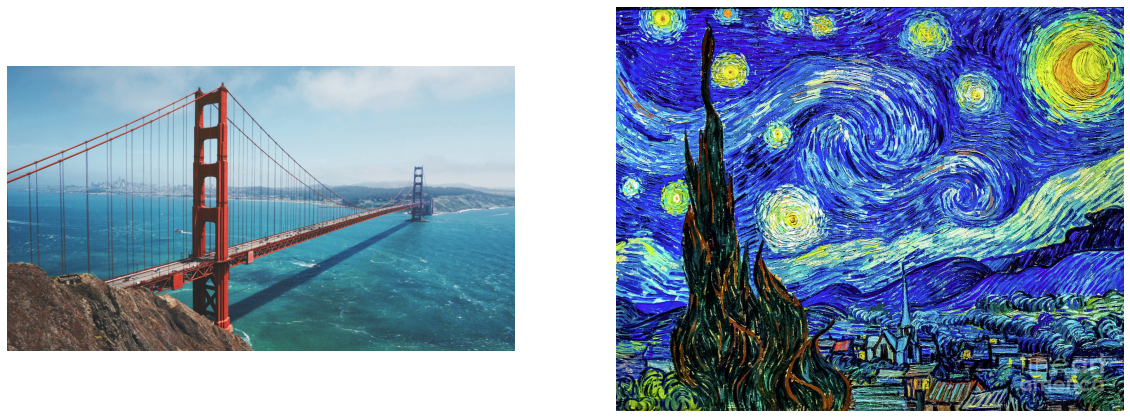

In [ ]:
f, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(np.asarray(base_image))
axarr[0].axis('off')
axarr[1].imshow(np.asarray(style_reference_image))
axarr[1].axis('off')
plt.show()


# Create model

Load VGG and get a dictionary of all its layers:

In [ ]:
import torchvision.models as models

model = models.vgg16(pretrained=True).features.to(device).eval()
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Here we choose the layers of the network that we want to use to represent the style and the content. You can play with different combinations if you wish.

In [ ]:
content_layers = [20]

style_layers = [0, 5, 10, 17, 24]

## Exercise 1
Complete the code to have a FeaturesExtractor module that returns 2 lists, one with the content and one with the style features.

**Hint:** You can use `for i, layer in enumerate(self.base_model):` to iterate the layers of the model in order one by one.

In [ ]:
import torch.nn as nn
class FeaturesExtractor(nn.Module):

    def __init__(self, base_model, content_layers, style_layers):
        super().__init__()
        self.base_model = base_model
        self.content_layers = content_layers
        self.style_layers = style_layers

    def forward(self, x):
        content_output = []
        style_output = []
        for i, layer in enumerate(self.base_model):
            x = self.base_model[i](x)
            if i in self.content_layers:
                content_output.append(x)
            if i in self.style_layers:
                style_output.append(x)
        return content_output, style_output


We don't need to compute the gradients of this model.

In [ ]:
feature_extractor = FeaturesExtractor(model, content_layers, style_layers)
for param in feature_extractor.parameters():
    param.requires_grad = False


# Loss functions

## Exercise 2
Complete the content loss and the style loss.

**Hint:** Remember that the content loss is Mean Square Error for the features, and the style loss is Mean Square Error for the Gram matrices of the features.

In [ ]:
content_loss = nn.MSELoss()

def gram_matrix(x):
    b, c, h, w = x.shape
    x = x.reshape(b, c, h*w)
    gram = torch.bmm(x, x.transpose(1, 2))/(h*w)
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    return F.mse_loss(S, C)


## Extra: Total variation loss

Adding the total variation loss to the training loop can help a bit in maintaining local coherence.

In [ ]:
def total_variation_loss(img):      
    tv_h = ((img[:,:,1:,:] - img[:,:,:-1,:]).pow(2)).mean()
    tv_w = ((img[:,:,:,1:] - img[:,:,:,:-1]).pow(2)).mean()    
    return tv_h + tv_w

# Prepare data

We will now prepare the data for the model.

In [ ]:
img_size = 512

transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
])

base_tensor = transform(base_image).to(device).unsqueeze(0)
style_reference_tensor = transform(style_reference_image).to(device).unsqueeze(0)


## Exercise 3
Create the `combination_tensor` with the same initial values as base_tensor. It will be the image that we will "train". Then, use `optim.LBFGS` as an optimizer to train it, with the default value for lr.

**Hint:** You can copy another tensor by using `.clone()`. Remember that trainable tensors have to have `requires_grad=True`

In [ ]:
combination_tensor = base_tensor.clone()
combination_tensor.requires_grad = True
combination_tensor = combination_tensor.to(device)
optimizer = optim.LBFGS([combination_tensor])


# Extract target features

In [ ]:
content_target, _ = feature_extractor(base_tensor)
_, style_target = feature_extractor(style_reference_tensor)
content_target = [ct.detach() for ct in content_target]
style_target = [st.detach() for st in style_target]


# Training loop

## Exercise 4

Complete the training loop. 

Take into account that the optimizer LBFGS requires a closure, which is a function that sets the gradients to 0, evaluates the model with the current data, computes the loss, computes the gradients and then returns the current loss. Remember to multiply each loss times the corresponding weight defined in the hyperparameters cell.



In [ ]:

images_history = []

for i in range(iterations):

    def closure():
        optimizer.zero_grad()
        loss = 0.0

        content_output, style_output = feature_extractor(combination_tensor)

        # Content loss
        cl = 0
        for orignal_feature, combination_feature in zip(content_target, content_output):
            cl += (content_weight / len(content_layers)) *content_loss(orignal_feature, combination_feature)
        loss += cl
        
        # Style loss
        sl = 0
        for orignal_feature, combination_feature in zip(style_target, style_output):
            sl += (style_weight / len(style_layers)) * style_loss(orignal_feature, combination_feature)
        loss +=  sl

        # Variation loss
        vl = variation_weight*total_variation_loss(combination_tensor)
        loss += vl

        if i % 2 == 0:
            print(f"[{i}] Content loss: {cl.item():.2f}, Style loss: {sl.item():.2f}, Variation loss: {vl.item():.2f}")

        loss.backward()
        return loss
    
    optimizer.step(closure)
    images_history.append(combination_tensor.clone().cpu().squeeze().detach().clamp(0, 1))


Content loss: 0.00, Style loss: 2857.13, Variation loss: 0.50
Content loss: 0.00, Style loss: 2856.72, Variation loss: 0.50
Content loss: 0.45, Style loss: 2163.52, Variation loss: 0.51
Content loss: 1.45, Style loss: 1599.92, Variation loss: 0.58
Content loss: 1.97, Style loss: 1121.96, Variation loss: 0.73
Content loss: 2.23, Style loss: 808.23, Variation loss: 0.93
Content loss: 2.67, Style loss: 617.78, Variation loss: 1.21
Content loss: 2.65, Style loss: 470.14, Variation loss: 1.51
Content loss: 2.74, Style loss: 391.56, Variation loss: 1.58
Content loss: 2.99, Style loss: 259.01, Variation loss: 1.82
Content loss: 2.91, Style loss: 224.46, Variation loss: 2.04
Content loss: 3.07, Style loss: 181.56, Variation loss: 2.15
Content loss: 3.18, Style loss: 161.98, Variation loss: 2.18
Content loss: 3.18, Style loss: 147.35, Variation loss: 2.20
Content loss: 3.15, Style loss: 117.96, Variation loss: 2.33
Content loss: 3.27, Style loss: 103.36, Variation loss: 2.41
Content loss: 3.27,

KeyboardInterrupt: ignored

In [ ]:
images_history = [transforms.functional.to_pil_image(im) for im in images_history]


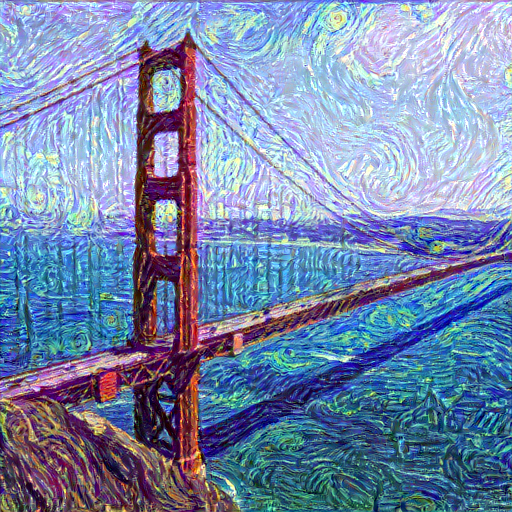

In [ ]:
images_history[-1]
